In [ ]:

using GLM
using DataFrames #NB: we are using pinned version 0.9.1 to match JuliaBox
using FreqTables
using Plots
using StatPlots
using Distributions
using RDatasets
using Suppressor
using DecisionTree
#https://github.com/JuliaLang/IJulia.jl/issues/448

function nfoldCV(classifier::Symbol,labels, features,maxdepth, args...)
    nfolds = args[end]
    if nfolds < 2
        return nothing
    end
    if classifier == :tree
        pruning_purity = args[1]
    elseif classifier == :forest
        nsubfeatures = args[1]
        ntrees = args[2]
        partialsampling = args[3]
    elseif classifier == :stumps
        niterations = args[1]
    end
    N = length(labels)
    ntest = _int(floor(N / nfolds))
    inds = randperm(N)
    accuracy = zeros(nfolds)
    for i in 1:nfolds
        test_inds = falses(N)
        test_inds[(i - 1) * ntest + 1 : i * ntest] = true
        train_inds = (!).(test_inds)
        test_features = features[inds[test_inds],:]
        test_labels = labels[inds[test_inds]]
        train_features = features[inds[train_inds],:]
        train_labels = labels[inds[train_inds]]
        if classifier == :tree
            model = build_tree(train_labels, train_features, 0,maxdepth)
            if pruning_purity < 1.0
                model = prune_tree(model, pruning_purity)
            end
            predictions = apply_tree(model, test_features)
        elseif classifier == :forest
            model = build_forest(train_labels, train_features, nsubfeatures, ntrees, partialsampling)
            predictions = apply_forest(model, test_features)
        elseif classifier == :stumps
            model, coeffs = build_adaboost_stumps(train_labels, train_features, niterations)
            predictions = apply_adaboost_stumps(model, coeffs, test_features)
        end
        cm = confusion_matrix(test_labels, predictions)
        accuracy[i] = cm.accuracy
        
    end

    return accuracy
end

##  Overview
 * Supervised Learning
 * (Genarlised) Linear Models  
 * Classification and Regression Trees
 * Neural Netwsorks




 


## Elements of supervised learning

 * Data set is collections of features $x_i$ and labels $y_i$ and the task  is to predict $y_i$ given $x_i$. A model can be formed on the basis of a training set $(x_i,y_i)_i$.
 * model is the mathematical structure to predict $Y$ from $x$ e.g. $Y=X \cdot \beta$ for a linear model
 * a model consists of parameters e.g. $\beta$ to be choosen
 * solving the learning tasks boils down to optimising $\beta$ e.g.
 $$ \text{obj}(\beta)=L(\beta)+\Omega(\beta) $$
 where $L(\theta) = \sum_i (y_i-\hat{y}_i(\beta))^2$ is the loss and $\Omega$ the regulariser (prevents over-fitting)
 * Side remark: Bayesian approach


(following XGBoost tutorial)

## Overfitting
![png](step_fit.png)

# (Generalised) Linear Models

The simplest and most underestimated models are linear models.

$Y=X\beta+\epsilon$

where $X\in \mathbb{R}^{n\times p}$ (predictor,feature), Y (response) and  $\epsilon$ is the noise and in the simplest setting is modelled as $\epsilon\sim\mathcal{N}(0,\sigma I)$.
 * The maximum likelihood estimator $$\hat{\beta}_{OLS}= \text{argmax}_\beta p(Y|\beta)\propto \exp\left( -\frac{1}{2} (Y-X\beta)^t (Y-X\beta) \right)$$.
Important considerations
    * $n\ll p$ - variable selection or regularisation needs to be performed
    * we would like as many entries of $\beta$ to be zero
Pointers 
 * Richard Samworth on Linear Models https://www.youtube.com/watch?v=5m3djtMGyHs
 * Here I follow James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112). New York: springer. P.
 * Elements of Statistical learning

Minimising quadratic form = solving linear equation

In [ ]:
boston=readtable("boston.csv")
head(boston)

In [ ]:
describe(boston)

We aim to predict (median house value)
medv using 13 predictors such as rm (average number of rooms per house), age (average age of houses), and lstat (percent of households with low socioeconomic status).


In [ ]:
@suppress fitols=lm(@formula( MedV~LStat),boston)
coef((fitols))

In [ ]:
p1=scatter(boston[:LStat],boston[:MedV],) 
xs=[1.0:40;]
plot!(xs,GLM.predict(fitols,DataFrame(LStat=xs)))


In [ ]:

@show GLM.r2(fitols)
p=scatter(GLM.predict(fitols),residuals(fitols)/var(residuals(fitols))^0.5)
xlabel!("fitted")
ylabel!("standardised residuals")


A common diagnostic used in statistics is the q-q plot. If we assume
data $X_{i}\overset{\text{iid}}{\sim} F$ where $F(t)=\mathbb{P}(X\leq t)$, then the q-q
plot is a plot of 
\begin{align*}
 & (F^{-1}(q),\hat{F}_{n}^{-1}(q))\;\tag{q-q plot}
\end{align*}
where $\hat{F}_{n}(t)$ is the empirical cdf given by 

$$
\hat{F}_{n}(t)=\frac{\mbox{number of elements in the sample}\leq t}{n}=\frac{1}{n}\sum_{i=1}^{n}\mathbf{1}_{X_{i}\le t}
$$
and $F^{-1}$ denotes the generalised inverse distribution function
given by 
$$
F^{-1}(p)=\inf\{x\in\mathbb{R}:F(x)\geq p\}.
$$
If $F$ is invertible, we can equivalently plot $\left(x,\hat{F}_{n}^{-1}(F(x))\right)$.
Provided $X_{i} \overset{\text{iid}}{\sim} F$ and $n$ is large $\hat{F}_{n}\approx F$
such that $F^{-1}(\hat{F}_{n}(t))$ and the plot would correspond
to a straight line. 


In [ ]:
 @suppress qqplot(randn(500),Normal())
title!("QQ-Plot")

In [ ]:
@suppress qqplot(residuals(fitols)/var(residuals(fitols))^0.5,Normal())

In [ ]:
# Multiple linear regression
fitols=lm(@formula( MedV~LStat+Age),boston)

In [ ]:
fitols=lm(@formula( MedV~LStat+(AgeSq)),hcat(boston,DataFrame(AgeSq=boston[:Age].^2)))

## Logistic Regression
We observe labels $Y_i \in \{0,1\} $ and have data $(x_i,y_i)$. We cannot apply linear regression directly but we can transform the using a link funciton.

We treat $Y$ as a random variable $$p=p(Y=1|x)=\mathbb{E}Y=g^{-1}(X\beta)=\frac{\exp(\beta_0+\beta_1 x)}{1+\exp(\beta_0+\beta_1 x)}$$ -  with $g(p)=\log (\frac{p}{1-p})$. Here choices for $g$ is the *logit* function - a common used alternative is  *probit*.

However, this is not only setting where generalized linear models (GLM)  can be used - other examples are count data - Poisson regression.

[https://en.wikipedia.org/wiki/Generalized_linear_model]

## Logistic function and probabalistic classification

 * the output of logistic regression are probabilities which need to be thresholded to obtain predictions of labels.
 * (threshold is typically $0.5$ can be higher/lower to reduce false positive/false negative)

In [ ]:
xs=[-5:0.1:5;];

@suppress plot(xs,GLM.logistic(xs))


In [ ]:
df=readtable("Default.csv", separator=';')
df[:flag]=1.0*(df[:default].=="Yes");
head(df)

In [ ]:
srand(17)

ind=shuffle(vcat(ones(60), zeros(nrow(df)-60))) .>0.1 
dftest=df[ind,:]
df=df[.!ind,:]

In [ ]:
@df df scatter(:balance,:income,group=:default)

In [ ]:
@suppress logreg=glm(@formula(flag~balance),df,Binomial(),LogitLink())

In [ ]:
p1=@df df[df[:,:default] .== "Yes",:] scatter(:balance,:income,group=:default,color="red")
p2=@df df[df[:,:default] .== "No",:] scatter(:balance,:income,group=:default)
plot(p1,p2)

logreg2=glm(@formula(flag~balance+income),df,Binomial(),LogitLink())

## Binary classification

$$\text{confussion matrix -}\left(\begin{array}{cc}
\text{TP: true positive} & \text{FP: false positive}\\
\text{FN: false negative} & \text{TN: true negative}
\end{array}\right)$$

![png](class1.png)
![png](class2.png)





# Classification and Regression Trees (CART) and decision trees

In this section we give some background to tree-based methods for classification and regression such as 
 * decision trees and cart
 * bagging, boosting
 * random forest. 
For this part we  follow James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112). New York: springer. P. 

## Recap Trees
![png](cart.png)

# One tree is not good enough
![png](twocart.png)
Additive model: $\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

In [ ]:
#Load data

df=readtable("Heart.csv")
train = rand(nrow(df)) .< 4/5 # make this random 20%
test = .!train 
traindf= df[train,:];
testdf=df[test,:] ;
head(df)


 * Plan: Observation in a given region to the most commonly occurring 
 * the classification error rate is the fraction that do not belong to the most common class:


![png](tree1.png)

## How are the splits above found? 
    
In order to perform  top-down greedy approach  (recursive binary splitting), we first select the feature $X_j$ and the cutpoint s such that splitting the predictor space into the regions {X|Xj < s} and {X|Xj ≥ s} leads to the greatest possible reduction in the loss chosen e.g.
 * Regression
  * residual sum of squares, $L^1$ etc
 * Classification (corresponding to region $m$ with proportion of $\hat{p}_{mk}$ having label $k$)
  1. Gini index $\sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$
  2. Entropy - $\sum_{k=1}^K \hat{p}_{mk} \log \hat{p}_{mk}$ (**used by DecisionTree.jl**)

.    

In [ ]:
cols=[5:12;]
features = convert(Array, traindf[:, cols]); featuresTest = convert(Array, testdf[:, cols]);
featurenames= names(traindf)[cols]
labels = convert(Array, traindf[:, end]); labelsTest = convert(Array, testdf[:, end]);
trainErr= Float64[];testErr= Float64[]; cvErr= Float64[];
treeSize=20
for i=1:treeSize
    model=build_tree(labels, features,0,i)
     
    if(i<4 )
        print("============== Depth=$i ===========\n");print_tree(model);
    end
    push!(trainErr,1-confusion_matrix(labels,DecisionTree.apply_tree(model,features)).accuracy)
    push!(testErr,1-confusion_matrix(labelsTest,DecisionTree.apply_tree(model,featuresTest)).accuracy)

    push!(cvErr,1-mean(nfoldCV(:tree,labels, features,i,5)))
end

In [ ]:
plot([1:treeSize],trainErr,label="Training")
plot!([1:treeSize],testErr,label="Test")
plot!([1:treeSize],cvErr,label="CV-5")
xlabel!("Depth of tree")
ylabel!("Classification error rate")

In [ ]:
#TODO exercise on pruning?

# Bagging

 * Bootstrapping and resampling strategies (also includes) more generally are often used  assess quality statistical estimators. The common idea is to randomly sample from the given data set to create artificial new data sets.  
 * Boostraping comes from the idea of pulling onself up grabbing ones own hair. Treating the new artificial data sets can be used to quantifiy the statistical variation allowing for a bias variance trade-off.  
 
For regression $f_{\text{bag}}(x)=\sum_{b=1}^B \hat{f}^{\star b}(x)$



**How can this implemented for classification?**







### Majority vote

In [ ]:
function majority_vote(labels::Vector)
    if length(labels) == 0
        return nothing
    end
    counts = _hist(labels)
    top_vote = labels[1]
    top_count = -1
    for (k,v) in counts
        if v > top_count
            top_vote = k
            top_count = v
        end
    end
    return top_vote
end

In [ ]:
## Bagging explicitly implemented

In [ ]:
B=50
maxdepth=10
ss=length(labels)
trees=[]
for i=1:B
    inds=sample([1:ss;],ss,replace=true) # BOOTSTRAP samples created
    push!(trees,build_tree(labels[inds], features[inds,:],0,5))
end
function apply_trees(trees,features)
   dec=hcat([apply_tree(t,features) for t in trees ]...);
   #decm=reshape(dec,div(length(dec),B))
    vec(mapslices(majority_vote,dec,2)) ## Majority vote
    
end
confusion_matrix(labelsTest,apply_trees(trees,featuresTest)).accuracy

## Random forest

 * bagging improves upon decision trees by allowing for different treestructures
 * however bootstraped are quite similar so decision trees might have a lot in common
 * **Random forests**:
     Grow many deep  trees to randomized versions of the training data, and average them. Here “randomized” is a wide-ranging term, and includes bootstrap sampling and/or subsampling of the observations, as well as subsampling of the variables.
 * **Boosting:** Repeatedly grow shallow trees to the residuals, and hence build up an additive model consisting of a sum of trees.

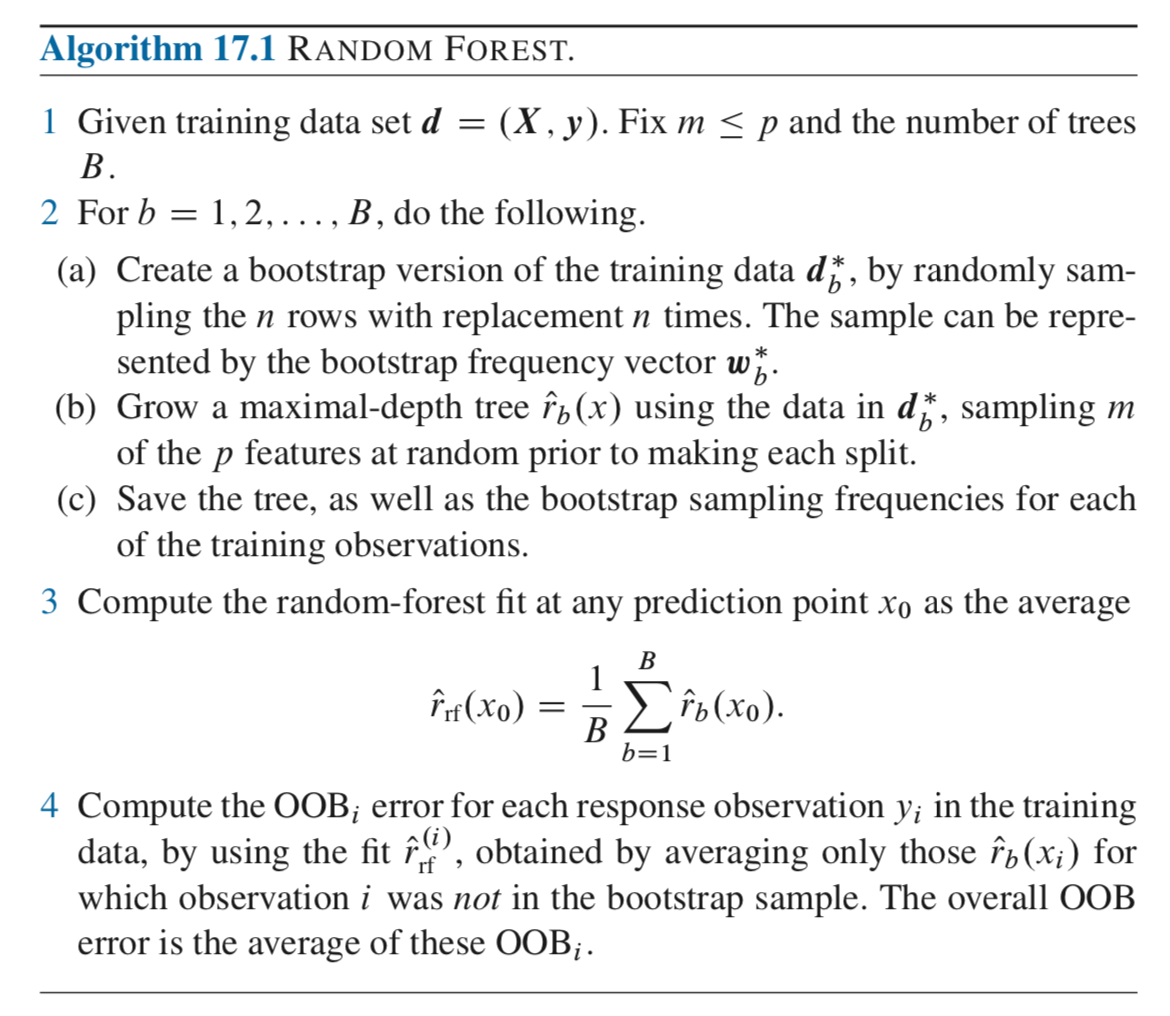

In [ ]:
rf_model = build_forest(labels, features, 3, 50, 1.0, 10)
# using 3 random features, 10 trees, 1.0 portion of samples per tree (optional), and a maximum tree depth of 6 (optional)
# apply learned model
confusion_matrix(labelsTest,apply_forest(rf_model,featuresTest)).accuracy

In [ ]:
rf_model = build_forest(labels, features, 4, 50, 1.0, 10)
# using 2 random features, 10 trees, 0.5 portion of samples per tree (optional), and a maximum tree depth of 6 (optional)
# apply learned model
confusion_matrix(labelsTest,apply_forest(rf_model,featuresTest)).accuracy

## Boosting 
RF is a special case of additive ensambeles:
$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

Gradient boosting is a different way to train an ensamble of trees
\begin{align}
\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{align}

$\text{obj} = \sum_{i=1}^n l_i(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i)$

At each step greedily optimises the additive loss-function.

Boosting has many different flavours - common theme reweighing the error at each step (learn from mistakes)

## AdaBoost
![png](tree2.png)

In [ ]:
adaerror=Float64[];
for i=1:20
    ada,coef=build_adaboost_stumps(labels,features,i)
    push!(adaerror,confusion_matrix(labelsTest,apply_adaboost_stumps(ada,coef,featuresTest)).accuracy)
end
plot([1:20;],adaerror)



## Probabilistic classifiers
By renormalising the output of $\hat{G}_b$. Adaboost can bee seen as a probabilistic classifier. The confussion matrix (see above) depends on the value of the threshold. This can be visualised by the ROC curve.

![png](roc.png)

In [ ]:
# Lets output probabilities
ada,coef=build_adaboost_stumps(labels,features,10);


In [ ]:
# thresholding yields prediction
function thres(x,t)
   if x<t 
        return "No"
    end
    return "Yes"
end

adares=(apply_adaboost_stumps_proba(ada,coef,featuresTest,["Yes","No"]))[:,1];

In [ ]:
ts=[0.0:0.05:1.0;]
function rocXY(mat)
   Float64[mat[2,2]/(mat[2,1]+mat[2,2]),mat[1,2]/(mat[1,1]+mat[1,2])]
end
function rocRate(t)
    res=confusion_matrix(labelsTest,map(x->thres(x,t),adares)).matrix *1.0
    rocXY(res)
end
res=hcat([rocRate(t) for t in ts]...)
plot(vec(res[1,:]),vec(res[2,:]))
title!("ROC")

## Outlook
 
 * variable importance plots a useful diagnostic for trees 
  * in the simplest instance they permuate column in the feature matrix in evaluate the impact on the performance.
 * There are many more boosting algorithms such as XGBoost.jl and  [LightGBM.jl](https://github.com/Allardvm /LightGBM.jl). We can attack the problem above using XGBoost as follows. 

In [ ]:
Pkg.add("XGBoost")

In [ ]:
using Compat
using  XGBoost

bst = xgboost(features, num_round, label = labels, eta = 1, max_depth = 2,
objective = "binary:logistic")
predict(bst, featuresTest)

# Bonus exercise 
The visualisaiions of trees is done purely in DecisionTree.jl. I made a quick attempt at rectifying this using [GraphViz.jl](https://github.com/Keno/GraphViz.jl). Feel free to come up with a nice visualisation and submit this to DecisionTree.jl

In [ ]:
using GraphViz
Graph("""
graph graphname {
     // The label attribute can be used to change the label of a node
     a [label="Foo"];
     // Here, the node shape is changed.
     b [shape=box];  // These edges both have different line properties
     a -- b -- c [color=blue];     b -- d [style=dotted];}
""")
Graph(graphstring)

In [ ]:
donen=[]
notdone=[(model,1)]
j=1
graphstring="graph tree {"
edgestring=""
while length(notdone)>0
    el,i=pop!(notdone)
   push!(donen,el) 
    graphstring*=  "p$(i) [label=\"$(featurenames[el.featid])\"];"*"\n"
    if typeof(el.left)!=DecisionTree.Leaf 
        j+=1
        push!(notdone,(el.left,j))
        edgestring*="p$(i)--p$(j);"
    else
        j+=1;
        graphstring*=  "p$(j) [label=\"$(featurenames[el.featid])\"];"*"\n"
        
    end
      if typeof(el.right)!=DecisionTree.Leaf 
        j+=1

        push!(notdone,(el.right,j))

        edgestring*="p$(i)--p$(j);"
    end
    
end
graphstring*=edgestring*"}"
mutable struct rd
    j::Int64
    graphstring::String
    edgestring::String
    featurenames
end

r=rd(1,"digraph tree{","p1",featurenames)

function GraphVizString(g,r::rd)

    i=r.j
    if(typeof(g)==DecisionTree.Leaf )
        r.graphstring*="p$(i) [shape=box];"
        r.edgestring*="->$(r.j);"
        return r;
    else 
        r.graphstring*="p$(i) [label=\"$(featurenames[g.featid])\"];\n"
        r.j+=1
        r.edgestring*="->p$(r.j)"
        r=GraphVizString(g.left,r)
        r.j+=1
        r.edgestring*="\n p$(i)"
        r=GraphVizString(g.right,r)
        return r;
        
    end

    
end

r=rd(1,"digraph tree{","p1",featurenames)

function GraphVizString(g,r::rd)

    i=r.j
    if(typeof(g)==DecisionTree.Leaf )
        r.graphstring*="p$(i) [shape=box];\n"
        return r;
    else 
        r.graphstring*="p$(i) [label=\"$(featurenames[g.featid])\"];\n"
        r.j+=1
        r.edgestring*="p$(i)->p$(r.j);\n"
        r=GraphVizString(g.left,r)
        r.j+=1
        r.edgestring*="p$(i)->p$(r.j);\n"
        r=GraphVizString(g.right,r)
        return r;
        
    end

    
end